<h1>Peer Graded Assignment - Research on Bakery Industry in Pune City,India</h1>

<h4>Importing Libraries</h4>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<h3>A) Data Cleaning

<h4> Reading the Scraped data acquired from geographic.org

In [3]:
df_cord = pd.read_csv(r'C:\Users\yash kumar vyas\Desktop\pune_coordinates-2.csv')
df_cord.head()

,Area Name,Postal Code,Latitude,Longitude
0,Adivare,410509,19.159047,73.696210
1,AFMC,411040,18.506342,73.890503
2,Agoti,413132,18.226457,74.975982
3,Airport,411032,18.578542,73.908641
4,Akurdi,411035,18.646468,73.774262


<h4>Appending data of important Locations that were missing in the above file. this was acquired from google

In [4]:
df_cord = df_cord.append(pd.DataFrame({"Area Name":['Koregaon Park', 'Kalyani Nagar', 'Boat Club Road', 'Sopan Baug', 'Undri', 'Fatima Nagar'],
              "Postal Code":['411001', '411006', '411001', '411001','411060','411022'],
              "Latitude":[18.536207,18.546328,18.539517,18.5142,18.4567,18.5042 ],
              "Longitude":[73.893974,73.903313,73.878978,73.9040,73.9095,73.9014]}), ignore_index=True)
#df2 = pd.DataFrame({"a":[1, 2, 3], 
#                    "b":[5, 6, 7]}) 
df_cord.head()

,Area Name,Postal Code,Latitude,Longitude
0,Adivare,410509,19.159047,73.696210
1,AFMC,411040,18.506342,73.890503
2,Agoti,413132,18.226457,74.975982
3,Airport,411032,18.578542,73.908641
4,Akurdi,411035,18.646468,73.774262


<h4>Sorting the data according to Area Name

In [6]:
df_cord.sort_values(['Area Name'], axis=0, inplace=True)
df_cord.head()

,Area Name,Postal Code,Latitude,Longitude
1,AFMC,411040,18.506342,73.890503
0,Adivare,410509,19.159047,73.696210
2,Agoti,413132,18.226457,74.975982
3,Airport,411032,18.578542,73.908641
4,Akurdi,411035,18.646468,73.774262


<h4>Filtering out data so that we can focus on Postal codes relating to just the main Pune City area

In [7]:
#converting postal code to string type
df_cord['Postal Code'] = df_cord['Postal Code'].astype(str)
Pune_filtered = df_cord[df_cord['Postal Code'].str.startswith('411')]
Pune_filtered.rename(columns = {'Area Name':'Neighborhood'}, inplace = True) 
Pune_filtered.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,Neighborhood,Postal Code,Latitude,Longitude
1,AFMC,411040,18.506342,73.890503
3,Airport,411032,18.578542,73.908641
4,Akurdi,411035,18.646468,73.774262
16,Ambegaon BK,411046,18.402869,73.853668
24,Ammunition Factory Khadki,411003,18.567988,73.857668


<h3>  Exploring Datasets

<b>Defining credentials for Foursquare

In [8]:
CLIENT_ID = 'A2V2SIQQ2T1ZI5EMEYMZD5GER4YTOMXLVSEVZ4NBXYWSZ1S2' # Foursquare ID
CLIENT_SECRET = 'O5YVJFZ2Q4H0R50FOLWXSV4JCVPWNYAKQUKPRH4S4V00SZQN' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 250
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: A2V2SIQQ2T1ZI5EMEYMZD5GER4YTOMXLVSEVZ4NBXYWSZ1S2
CLIENT_SECRET:O5YVJFZ2Q4H0R50FOLWXSV4JCVPWNYAKQUKPRH4S4V00SZQN


<h4>Define a function for getting json file and converting it to a dataframe with venues

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        results = results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h4> Feed in Pune filtered dataset in the function

In [10]:
Pune_venues = getNearbyVenues(names=Pune_filtered['Neighborhood'],
                                   latitudes=Pune_filtered['Latitude'],
                                   longitudes=Pune_filtered['Longitude'],
                                   radius = 400
                                  )

AFMC          
Airport          
Akurdi          
Ambegaon BK        
Ammunition Factory Khadki      
Anandnagar          
Armament          
Aundh Camp        
Aundh T.S.        
Aundh          
Bajirao Road        
Baner Gaon        
Baner Road        
Bavdhan          
Bhavani Peth        
Bhosari I.E.        
Bhosarigoan          
Bhusari Colony        
Bibvewadi          
Boat Club Road
Botanical Garden        
C D A      
C M E      
Chikhali          
Chikhlee          
Chinchwad East        
Chinchwadgaon          
Congress House Road      
Dapodi Bazar        
Dapodi          
Deccan Gymkhana        
Dhankawadi          
Dhanori          
Dhayari          
Dighi Camp        
Donje          
Dr.B.A. Chowk        
Dukirkline          
East Khadki        
Ex. Serviceman Colony      
Fatima Nagar
Film Institute        
Ganeshkhind          
Ghorpade Peth        
Ghorpuri Bazar        
Gokhalenagar          
Gondhale Nagar        
Govt. Polytechnic        
Guruwar Peth        
H.E.

In [11]:
Pune_venues.to_csv('Pune_ven.csv')
#Checking size of the resulting dataframe
print(Pune_venues.shape)
Pune_venues.head()

(852, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AFMC,18.506342,73.890503,Royal Western Indian Turf Club,18.507033,73.890641,Racetrack
1,AFMC,18.506342,73.890503,Race Course,18.506485,73.892134,Track Stadium
2,AFMC,18.506342,73.890503,mongiri's,18.506278,73.893868,Cupcake Shop
3,Airport,18.578542,73.908641,Pune Airport Arrival,18.578718,73.909355,Airport Service
4,Airport,18.578542,73.908641,Chicago Crust,18.579498,73.908478,Pizza Place


<h4> Filtering dataset to check neighborhood wise bakeries  

In [13]:
Bakery = Pune_venues[Pune_venues['Venue Category'].str.startswith('Bakery')]
print(Bakery.shape)
Bakery.head()

(29, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
11,Airport,18.578542,73.908641,Baker Street,18.579810,73.908800,Bakery
33,Aundh,18.555964,73.804439,La Bouchee d'Or,18.558395,73.803787,Bakery
50,Aundh,18.555964,73.804439,Sugardough,18.557765,73.805085,Bakery
99,Bhusari Colony,18.508581,73.795821,Mongini's,18.507878,73.795412,Bakery
111,Bibvewadi,18.480641,73.862557,Monginis Cake Shop,18.480774,73.865553,Bakery


<h4>Function for acquiring zone wise data


In [14]:

def getNearbyVenueszone(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        results = results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zone', 
                  'Zone Latitude', 
                  'Zone Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h4>Defining zone wise data


In [19]:

zones = pd.DataFrame({"Zone":['Center', 'North', 'East', 'South', 'West'],
              
              "Latitude":[18.513021,18.578542,18.562776,18.480641,18.498793],
              "Longitude":[73.878765,73.908641,73.937058,73.862557,73.821123]})
zones.head()

,Zone,Latitude,Longitude
0,Center,18.513021,73.878765
1,North,18.578542,73.908641
2,East,18.562776,73.937058
3,South,18.480641,73.862557
4,West,18.498793,73.821123


<h4> Feed in Zone dataset in the function

In [20]:
Zone_venues = getNearbyVenueszone(names=zones['Zone'],
                                   latitudes=zones['Latitude'],
                                   longitudes=zones['Longitude'],
                                   radius = 6000
                                  )

Center
North
East
South
West


In [21]:
Zone_venues.to_csv('Zone_ven')
print(Zone_venues.shape)#checking shape of Zone wise data
Zone_venues.head()

(500, 7)


,Zone,Zone Latitude,Zone Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Center,18.513021,73.878765,Kayani Bakery,18.514797,73.879860,Bakery
1,Center,18.513021,73.878765,Venky's Chicken,18.513503,73.879766,Fast Food Restaurant
2,Center,18.513021,73.878765,Thousand Oaks / 1000 Oaks,18.510672,73.879993,Bar
3,Center,18.513021,73.878765,JJ Garden Wada Pav,18.516492,73.878835,Food Truck
4,Center,18.513021,73.878765,Main Street,18.516229,73.878812,Plaza


<h4>Filter bakery data </h4>

In [28]:
Zone_Bakery = Zone_venues[Zone_venues['Venue Category'].str.startswith('Bakery')]
print(Zone_Bakery.shape)
Zone_Bakery.head()

(16, 7)


,Zone,Zone Latitude,Zone Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Center,18.513021,73.878765,Kayani Bakery,18.514797,73.879860,Bakery
37,Center,18.513021,73.878765,La Bouchee d'Or,18.538931,73.876677,Bakery
40,Center,18.513021,73.878765,Modern Cakes,18.534795,73.897673,Bakery
47,Center,18.513021,73.878765,the French Window Patisserie,18.537709,73.897990,Bakery
88,Center,18.513021,73.878765,Arkie's Born Baker's,18.484204,73.884479,Bakery


<h4>Checking zone wise count for bakeries

In [29]:
ZBP = Zone_Bakery.groupby('Zone').count()
ZBP.head()

,Zone Latitude,Zone Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Zone,,,,,,
Center,5,5,5,5,5,5
East,3,3,3,3,3,3
North,4,4,4,4,4,4
South,2,2,2,2,2,2
West,2,2,2,2,2,2


In [30]:
#Store database in a DataFrame
Zone_Bakery_plot = pd.DataFrame(ZBP)

<h4>Ploting zone wise bakeries

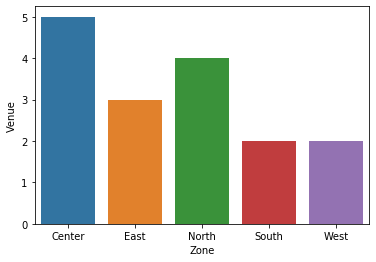

In [32]:
#Zonewise bar plot
import seaborn as sns
sns.barplot(x =Zone_Bakery_plot.index, y = Zone_Bakery_plot['Venue'], data = Zone_Bakery_plot)

In [80]:
PZ_Venues = pd.merge(Pune_venues, Zone_venues, how='inner', on=['Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
print(PZ_Venues.shape)
PZ_Venues.head()

(230, 10)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Zone,Zone Latitude,Zone Longitude
0,AFMC,18.506342,73.890503,Royal Western Indian Turf Club,18.507033,73.890641,Racetrack,Center,18.513021,73.878765
1,AFMC,18.506342,73.890503,Royal Western Indian Turf Club,18.507033,73.890641,Racetrack,South,18.480641,73.862557
2,Bajirao Road,18.513567,73.853342,Sujata Mastani,18.511793,73.852145,Ice Cream Shop,Center,18.513021,73.878765
3,Bajirao Road,18.513567,73.853342,Sujata Mastani,18.511793,73.852145,Ice Cream Shop,South,18.480641,73.862557
4,Bajirao Road,18.513567,73.853342,Sujata Mastani,18.511793,73.852145,Ice Cream Shop,West,18.498793,73.821123


In [87]:
PZ_Venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Zone,Zone Latitude,Zone Longitude
Neighborhood,,,,,,,,,
AFMC,2,2,2,2,2,2,2,2,2
Bajirao Road,9,9,9,9,9,9,9,9,9
Bibvewadi,4,4,4,4,4,4,4,4,4
Boat Club Road,8,8,8,8,8,8,8,8,8
Deccan Gymkhana,19,19,19,19,19,19,19,19,19


In [88]:
print('There are {} uniques categories.'.format(len(PZ_Venues['Venue Category'].unique())))

There are 43 uniques categories.


In [89]:
# one hot encoding
PZ_onehot = pd.get_dummies(PZ_Venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
PZ_onehot['Neighborhood'] = PZ_Venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [PZ_onehot.columns[-1]] + list(PZ_onehot.columns[:-1])
PZ_onehot = PZ_onehot[fixed_columns]
print(PZ_onehot.shape)
PZ_onehot.head()

(230, 44)


,Neighborhood,Asian Restaurant,BBQ Joint,Bakery,Bar,Bistro,Breakfast Spot,Burger Joint,Café,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Food,Food Truck,General Entertainment,Gym,Gym / Fitness Center,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Kebab Restaurant,Lounge,Multiplex,Nightclub,Organic Grocery,Park,Parsi Restaurant,Plaza,Racetrack,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Snack Place,Southern / Soul Food Restaurant,Sports Bar,Stadium,Theme Park,Trail,Vegetarian / Vegan Restaurant
0,AFMC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,AFMC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Bajirao Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bajirao Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bajirao Road,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<h4> Now let's check how many venues were returned for each neighborhood

In [110]:
PZ_grouped = PZ_onehot.groupby('Neighborhood').mean()
PZ_grouped.head()


,Asian Restaurant,BBQ Joint,Bakery,Bar,Bistro,Breakfast Spot,Burger Joint,Café,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Food,Food Truck,General Entertainment,Gym,Gym / Fitness Center,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Kebab Restaurant,Lounge,Multiplex,Nightclub,Organic Grocery,Park,Parsi Restaurant,Plaza,Racetrack,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Snack Place,Southern / Soul Food Restaurant,Sports Bar,Stadium,Theme Park,Trail,Vegetarian / Vegan Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFMC,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Bajirao Road,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Bibvewadi,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.250000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.750000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Boat Club Road,0.0,0.000000,0.25,0.25,0.0,0.0,0.0,0.000000,0.375,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Deccan Gymkhana,0.0,0.157895,0.00,0.00,0.0,0.0,0.0,0.157895,0.000,0.105263,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.263158


In [118]:
#PZ_grouped = PZ_grouped.drop('Pune')
PZ_grouped_fine = PZ_grouped.drop(['General Entertainment', 'Gym', 'Gym / Fitness Center', 'Historic Site', 'History Museum', 'Hotel','Lounge','Nightclub','Organic Grocery','Park','Plaza','Racetrack','Stadium','Theme Park','Trail','Bar','Sports Bar'], axis = 1)
PZ_grouped_fine.head()

,Asian Restaurant,BBQ Joint,Bakery,Bistro,Breakfast Spot,Burger Joint,Café,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Food,Food Truck,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Kebab Restaurant,Multiplex,Parsi Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Snack Place,Southern / Soul Food Restaurant,Vegetarian / Vegan Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,
AFMC,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
Bajirao Road,0.0,0.000000,0.00,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
Bibvewadi,0.0,0.000000,0.00,0.0,0.0,0.0,0.250000,0.000,0.000000,0.000000,0.0,0.0,0.750000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
Boat Club Road,0.0,0.000000,0.25,0.0,0.0,0.0,0.000000,0.375,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
Deccan Gymkhana,0.0,0.157895,0.00,0.0,0.0,0.0,0.157895,0.000,0.105263,0.157895,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.157895,0.0,0.0,0.0,0.0,0.263158


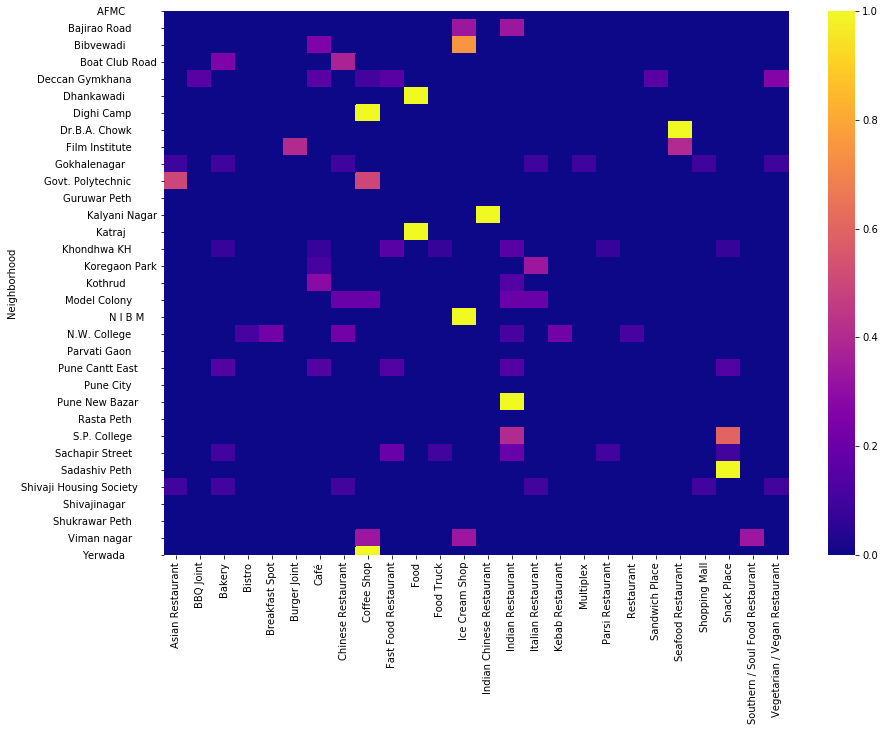

In [119]:
import matplotlib.pyplot as plt
PZ_fine = PZ_grouped_fine.drop([PZ_grouped_fine.index[24]])
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(PZ_fine, cmap='plasma', ax=ax)

<h4>Data exploration for clustering

In [130]:
Pune_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AFMC,3,3,3,3,3,3
Airport,11,11,11,11,11,11
Akurdi,4,4,4,4,4,4
Ammunition Factory Khadki,1,1,1,1,1,1
Anandnagar,1,1,1,1,1,1


<h4> Finding out how many unique categories can be curated from all the returned venues

In [120]:
print('There are {} uniques categories.'.format(len(Pune_venues['Venue Category'].unique())))

There are 143 uniques categories.


<h4> Using one hot encoding for Venues

In [131]:
# one hot encoding
Pune_onehot = pd.get_dummies(Pune_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Pune_onehot['Neighborhood'] = Pune_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Pune_onehot.columns[-1]] + list(Pune_onehot.columns[:-1])
Pune_onehot = Pune_onehot[fixed_columns]

Pune_onehot.head()

,Neighborhood,ATM,Afghan Restaurant,Airport Food Court,Airport Service,Airport Terminal,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Bed & Breakfast,Bistro,Bookstore,Breakfast Spot,Burger Joint,Bus Station,Business Service,Café,Cantonese Restaurant,Chaat Place,Cheese Shop,Chinese Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,General Entertainment,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Historic Site,History Museum,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Lake,Lounge,Maharashtrian Restaurant,Malay Restaurant,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Nightclub,North Indian Restaurant,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Parsi Restaurant,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Punjabi Restaurant,Racetrack,Resort,Restaurant,Road,Sandwich Place,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Vegetarian / Vegan Restaurant,Watch Shop,Women's Store,Yoga Studio,Zoo
0,AFMC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,AFMC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,AFMC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Airport,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Airport,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [132]:
Pune_onehot.shape

(852, 144)

<h4> Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [133]:
Pune_grouped = Pune_onehot.groupby('Neighborhood').mean().reset_index()
Pune_grouped.head()

,Neighborhood,ATM,Afghan Restaurant,Airport Food Court,Airport Service,Airport Terminal,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Bed & Breakfast,Bistro,Bookstore,Breakfast Spot,Burger Joint,Bus Station,Business Service,Café,Cantonese Restaurant,Chaat Place,Cheese Shop,Chinese Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,General Entertainment,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Historic Site,History Museum,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Lake,Lounge,Maharashtrian Restaurant,Malay Restaurant,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Nightclub,North Indian Restaurant,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Parsi Restaurant,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Punjabi Restaurant,Racetrack,Resort,Restaurant,Road,Sandwich Place,Seafood Restaurant,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Vegetarian / Vegan Restaurant,Watch Shop,Women's Store,Yoga Studio,Zoo
0,AFMC,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Airport,0.0,0.0,0.090909,0.090909,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.090909,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.090909,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Akurdi,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ammun

In [134]:
Pune_grouped.shape

(117, 144)

<h4> Let's print each neighborhood along with the top 5 most common venues

In [135]:
num_top_venues = 5

for hood in Pune_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Pune_grouped[Pune_grouped['Neighborhood'] == hood].T.reset_index()
    
    #print(temp)
    temp.columns = ['venue','freq']
    #print(temp)
    temp = temp.iloc[1:]
    
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----AFMC          ----
             venue  freq
0     Cupcake Shop  0.33
1        Racetrack  0.33
2    Track Stadium  0.33
3              ATM  0.00
4  Organic Grocery  0.00


----Airport          ----
                venue  freq
0         Snack Place  0.18
1              Bakery  0.09
2  Airport Food Court  0.09
3     Airport Service  0.09
4    Airport Terminal  0.09


----Akurdi          ----
                           venue  freq
0                     Playground  0.25
1           Fast Food Restaurant  0.25
2                Thai Restaurant  0.25
3  Paper / Office Supplies Store  0.25
4                Motorcycle Shop  0.00


----Ammunition Factory Khadki      ----
                            venue  freq
0                             ATM   1.0
1                 Organic Grocery   0.0
2              Mughlai Restaurant   0.0
3  Multicuisine Indian Restaurant   0.0
4                       Multiplex   0.0


----Anandnagar          ----
                            venue  freq
0                

                  venue  freq
0     Indian Restaurant  0.29
1  Fast Food Restaurant  0.08
2        Breakfast Spot  0.08
3        Ice Cream Shop  0.05
4                   Bar  0.05


----Kondhwa Lh        ----
                venue  freq
0                Café   0.4
1            Pharmacy   0.2
2  Falafel Restaurant   0.2
3      Breakfast Spot   0.2
4                 ATM   0.0


----Koregaon Park----
                venue  freq
0                Café   0.2
1  Italian Restaurant   0.1
2   Indian Restaurant   0.1
3              Lounge   0.1
4            Creperie   0.1


----Kothrud          ----
               venue  freq
0  Indian Restaurant  0.17
1               Café  0.08
2                Gym  0.08
3                Pub  0.08
4          Multiplex  0.08


----Lohogaon          ----
                            venue  freq
0                             ATM   0.5
1                  Mattress Store   0.5
2                           Motel   0.0
3              Mughlai Restaurant   0.0
4  Multicuis

4  Multicuisine Indian Restaurant   0.0




<h4> Let's put that into a *pandas* dataframe

In [136]:
#Function sorted values
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [137]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Pune_grouped['Neighborhood']

for ind in np.arange(Pune_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Pune_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,AFMC,Cupcake Shop,Racetrack,Track Stadium,English Restaurant,Food
1,Airport,Snack Place,Pizza Place,Fast Food Restaurant,Bakery,Smoke Shop
2,Akurdi,Playground,Fast Food Restaurant,Paper / Office Supplies Store,Thai Restaurant,English Restaurant
3,Ammunition Factory Khadki,ATM,Exhibit,Food & Drink Shop,Food,Flea Market
4,Anandnagar,Café,Zoo,Dance Studio,Food & Drink Shop,Food


<h4> Clustering Neighborhoods using K-means

In [138]:
# set number of clusters
kclusters = 5

Pune_grouped_clustering = Pune_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Pune_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

array([0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0])

<h4> Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [139]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Pune_merged = Pune_filtered

# merge Pune_grouped with Pune_data to add latitude/longitude for each neighborhood
Pune_merged = Pune_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Pune_merged.head() # check the last columns!
New_Pune = Pune_merged.dropna(axis = 0, how ='any')
convert_dict = {'Cluster Labels': int, 
               } 
  
New_Pune = New_Pune.astype(convert_dict) 
New_Pune.head()

,Neighborhood,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,AFMC,411040,18.506342,73.890503,0,Cupcake Shop,Racetrack,Track Stadium,English Restaurant,Food
3,Airport,411032,18.578542,73.908641,0,Snack Place,Pizza Place,Fast Food Restaurant,Bakery,Smoke Shop
4,Akurdi,411035,18.646468,73.774262,0,Playground,Fast Food Restaurant,Paper / Office Supplies Store,Thai Restaurant,English Restaurant
24,Ammunition Factory Khadki,411003,18.567988,73.857668,0,ATM,Exhibit,Food & Drink Shop,Food,Flea Market
26,Anandnagar,411051,17.252763,74.175439,1,Café,Zoo,Dance Studio,Food & Drink Shop,Food


<h4> Finally, let's visualize the resulting clusters

In [140]:
# create map
latitude = 18.516726
longitude = 73.856255
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(New_Pune['Latitude'], New_Pune['Longitude'], New_Pune['Neighborhood'], New_Pune['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

    
for lat1, lon1, poi1, ven1 in zip(Bakery['Venue Latitude'], Bakery['Venue Longitude'], Bakery['Neighborhood'], Bakery['Venue']):
    label1 = folium.Popup(str(ven1) + str(poi1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label1,
        color='b',
        fill=True,
        fill_color='r',
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

<h4> Examining Each Cluster

<b>Cluster 0

In [141]:
New_Pune.loc[New_Pune['Cluster Labels'] == 0, New_Pune.columns[[1] + list(range(5, New_Pune.shape[1]))]]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,411040,Cupcake Shop,Racetrack,Track Stadium,English Restaurant,Food
3,411032,Snack Place,Pizza Place,Fast Food Restaurant,Bakery,Smoke Shop
4,411035,Playground,Fast Food Restaurant,Paper / Office Supplies Store,Thai Restaurant,English Restaurant
24,411003,ATM,Exhibit,Food & Drink Shop,Food,Flea Market
35,411021,Flea Market,Farmers Market,Paper / Office Supplies Store,Zoo,Exhibit
43,411007,Furniture / Home Store,Bar,Zoo,Falafel Restaurant,Food & Drink Shop
41,411007,Ice Cream Shop,Dessert Shop,Bakery,Café,Indian Restaurant
47,411002,Ice Cream Shop,Indian Restaurant,Dessert Shop,Snack Place,Breakfast Spot
85,411026,Hotel,Zoo,Exhibit,Food & Drink Shop,Food
84,411039,ATM,Exhibit,Food & Drink Shop,Food,Flea Market


<b>Cluster 1

New_Pune.loc[New_Pune['Cluster Labels'] == 1, New_Pune.columns[[1] + list(range(5, New_Pune.shape[1]))]]

<b>Cluster 2

In [143]:
New_Pune.loc[New_Pune['Cluster Labels'] == 2, New_Pune.columns[[1] + list(range(5, New_Pune.shape[1]))]]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
130,411012,Electronics Store,Zoo,Exhibit,Food & Drink Shop,Food
200,411042,Food & Drink Shop,Fruit & Vegetable Store,History Museum,Snack Place,Exhibit
266,411002,Fruit & Vegetable Store,Food & Drink Shop,Electronics Store,Zoo,Falafel Restaurant
585,411002,Food & Drink Shop,Zoo,Exhibit,Food,Flea Market


<b>Cluster 3

In [144]:
New_Pune.loc[New_Pune['Cluster Labels'] == 3, New_Pune.columns[[1] + list(range(5, New_Pune.shape[1]))]]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
289,411011,Coffee Shop,Zoo,Exhibit,Food & Drink Shop,Food
420,411011,Coffee Shop,Zoo,Exhibit,Food & Drink Shop,Food
783,411006,Coffee Shop,Zoo,Exhibit,Food & Drink Shop,Food


<b>Cluster 4

In [145]:
New_Pune.loc[New_Pune['Cluster Labels'] == 4, New_Pune.columns[[1] + list(range(5, New_Pune.shape[1]))]]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
42,411027,Indian Restaurant,Snack Place,Vegetarian / Vegan Restaurant,Café,Zoo
49,411045,Indian Restaurant,Lounge,Breakfast Spot,Juice Bar,Café
50,411008,Park,Zoo,Exhibit,Food & Drink Shop,Food
56,411021,Food Court,Indian Restaurant,Exhibit,Food & Drink Shop,Food
72,411042,Platform,Indian Restaurant,Snack Place,Diner,Furniture / Home Store
103,411001,ATM,Art Gallery,Garden Center,Pizza Place,Indian Restaurant
156,411015,Café,Indian Restaurant,Coffee Shop,Zoo,Falafel Restaurant
191,411028,Indian Restaurant,Pizza Place,Zoo,English Restaurant,Food
193,411016,Indian Restaurant,Multiplex,Lounge,Ice Cream Shop,Bookstore
207,411003,Park,Zoo,Exhibit,Food & Drink Shop,Food


<h4> We can observe that cluster 4 seems to be more suited for food and eateries. It also seems to be having bakeries in its most preferred venues. Hence cluster 4 is more suited compared to the other clusters.
    
<h4> Lets check how many neighborhoods belong to this cluster but do not have a bakery yet.

In [146]:
Cluster4_Data = New_Pune.loc[New_Pune['Cluster Labels'] == 4, New_Pune.columns[[1] + list(range(5, New_Pune.shape[1]))]]
Pune_Venues_PC = pd.merge(Pune_venues, Pune_filtered, how='left', on=['Neighborhood'])
Pune_Venues_PC.shape
#Pune_Cluster4 = Pune_venues[Pune_venues['Postal Code'].isin(Cluster4_Data['Postal Code'])]

(852, 10)

In [147]:
Pune_Venues_PC.columns

Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category',
       'Postal Code', 'Latitude', 'Longitude'],
      dtype='object')

In [101]:
#Resetting the column order
Pune_Venues_PC = Pune_Venues_PC[['Neighborhood', 'Postal Code', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Latitude', 'Longitude']]
Pune_Venues_PC.head()

,Neighborhood,Postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Latitude,Longitude
0,AFMC,411040,18.506342,73.890503,Royal Western Indian Turf Club,18.507033,73.890641,Racetrack,18.506342,73.890503
1,AFMC,411040,18.506342,73.890503,Race Course,18.506485,73.892134,Track Stadium,18.506342,73.890503
2,AFMC,411040,18.506342,73.890503,mongiri's,18.506278,73.893868,Cupcake Shop,18.506342,73.890503
3,Airport,411032,18.578542,73.908641,Pune Airport Arrival,18.578718,73.909355,Airport Service,18.578542,73.908641
4,Airport,411032,18.578542,73.908641,Relay Bookstore,18.579464,73.908680,Bookstore,18.578542,73.908641


<h4>Filtering data of all the Pune Neighborhoods as per cluster 4

In [148]:
PC_merged_cluster4 = Pune_Venues_PC[Pune_Venues_PC['Postal Code'].isin(Cluster4_Data['Postal Code'])]
print(PC_merged_cluster4.shape)
PC_merged_cluster4.head()

(534, 10)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Postal Code,Latitude,Longitude
18,Ammunition Factory Khadki,18.567988,73.857668,State Bank of India ATM,18.569928,73.856792,ATM,411003,18.567988,73.857668
20,Armament,18.537086,73.795187,PASHAN CIRCLE BHAAJI MANDAI,18.537299,73.794286,Flea Market,411021,18.537086,73.795187
21,Armament,18.537086,73.795187,Pashan circle sabji market,18.537707,73.795101,Farmers Market,411021,18.537086,73.795187
22,Armament,18.537086,73.795187,dtdc Plus,18.533764,73.793953,Paper / Office Supplies Store,411021,18.537086,73.795187
23,Aundh Camp,18.501009,73.832877,Coffee & Bread Art Cafe,18.504055,73.830868,Café,411027,18.501009,73.832877


<h4>Let's check how many Neighborhooods have bakeries in cluster 4


In [149]:
Cluster4_Bakery = PC_merged_cluster4[PC_merged_cluster4['Venue Category'] == 'Bakery']
Cluster4_Bakery.head()
print(Cluster4_Bakery.shape)

(17, 10)


<h4>Finally, lets get all the potential areas which do not have bakeries

In [150]:
Cluster4_NO_Bakery = PC_merged_cluster4[PC_merged_cluster4['Venue Category'] != 'Bakery']
Cluster4_NO_Bakery_gp = Cluster4_NO_Bakery.groupby('Postal Code').first()
print(Cluster4_NO_Bakery_gp.shape)
Cluster4_NO_Bakery_gp.head()

(23, 9)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Latitude,Longitude
Postal Code,,,,,,,,,
411001,Boat Club Road,18.539517,73.878978,Suonmoi Chinese Restaurant,18.537519,73.879841,Chinese Restaurant,18.539517,73.878978
411003,Ammunition Factory Khadki,18.567988,73.857668,State Bank of India ATM,18.569928,73.856792,ATM,18.567988,73.857668
411005,Congress House Road,18.523303,73.853551,Sai Service Bajaj,18.522260,73.850185,Motorcycle Shop,18.523303,73.853551
411008,Baner Road,18.537880,73.804824,NCL Jogger's Park,18.538600,73.808394,Park,18.537880,73.804824
411015,Dighi Camp,18.572696,73.910359,Reddy's,18.571088,73.911399,Indian Restaurant,18.572696,73.910359


<h4>Let's plots these areas to better understand there locations on map.

In [116]:
# create map for bakeries
latitude = 18.516726
longitude = 73.856255
map_bak = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
#markers_colors = []
for lat, lon, poi in zip(Cluster4_NO_Bakery_gp['Venue Latitude'], Cluster4_NO_Bakery_gp['Venue Longitude'], Cluster4_NO_Bakery_gp['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='b',
        fill=True,
        fill_color='r',
        fill_opacity=0.9).add_to(map_bak)
       
map_bak

<b>Result:</b>

The Machine Learning Algorithmn categorises the data into five clusters(0,1,2,3,4) after analysing and examining the cluster, I found that cluster 4 locations were the closest to the type of location that match the audience preferences for bakeries.

Upon extracting the data comprising to Cluster 4 it was found that about 23 such areas in the main Pune city which belonged to Cluster 4 but did not have a single bakery in its viscinity.

<b>Discussion:</b>

Areas like Warje, Katraj and Khadakwasla fall in the main city but are a little on the outskirts of the city.
They may not be the best areas to be considered even though they fall in the selected cluster. 

Some of the pockets, inspite of being in the central zone of the city might not appeal to an audience looking for premium bakery products. Since our brand falls in the premium category we may not consider these as well.

We can see from the map that areas like Kalyani Nagar, Aundh, Model Colony and Keshav Nagar do not have sufficient bakeries but might be excellent locations for our bakery


<b>Conclusion:</b>

The above map shows areas which share similar characteristics to the areas which have good number of bakeries. 
However, would like you to note that our data is only based on Bakery category in general and does not involve any sub-categories of bakeries depending on product types, ratings, price, menu, premium or non-premium etc, due to lack of readlily available data.
Hence these recommendations may not be taken as final recomemndations and only be taken as basis for further advanced analysis.